In [1]:
import os

import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.utils.data as data

In [2]:

# 定义dataset
class my_Dataset(data.Dataset):#继承？
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [3]:
class TrafficDataset:
    def __init__(self, sensor_num=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = np.load('./traffic-flow/traffic.npz')['data']
        self.sensor_num = sensor_num
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=12,label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        len_train = int(self.data.shape[0] * train_por)
        len_val = int(self.data.shape[0] * val_por)
        len_test = int(self.data.shape[0] * test_por)
        train_seqs = self.data[:len_train]
        val_seqs = self.data[len_train:len_val+len_train]
        test_seqs = self.data[len_train+len_val:len_val+len_train+len_test]

        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            train_y.append(train_seqs[i+window_size, self.sensor_num, self.target].squeeze())

        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(val_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            val_y.append(val_seqs[i+window_size, self.sensor_num, self.target].squeeze())

        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            test_y.append(test_seqs[i+window_size, self.sensor_num, self.target].squeeze())
        
        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

In [5]:
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set()
batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

In [13]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size

        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))

        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()

        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        # x batch_size X seq_len X input_size
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            # x[:, i, :] (batch_size,input_size).* self.w_h (input_size,hidden_size)
            # h (batch_size,hidden_size) .* self.u_h (hidden_size,hidden_size)
            # h (batch_size,hidden_size) .* self.w_y (hidden_size, output_size) -> y (batch_size, output_size)
            # (batch_size, hidden_size)
            h = self.tanh(torch.matmul(
                x[:, i, :], self.w_h) + torch.matmul(h, self.u_h) + self.b_h)
            # (batch_size, output_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)
            y_list.append(y)  # seq_len X batch_size X output_size
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        # torch.stack(y_list, dim=1)把(seq_len,batch_size,output_size)转为(batch_size,seq_len,output_size)
        out_y = torch.stack(y_list, dim=1)
        #print(out_y.size())
        return out_y, h


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
print(input_size, hidden_size, output_size)
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

3 64 1


In [16]:
from utils import *

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0104, train rmse 100.9858, val loss 0.0037, val rmse 60.819962, time use 1.090s
*** epoch2, train loss 0.0032, train rmse 63.8153, val loss 0.0025, val rmse 48.347326, time use 1.028s
*** epoch3, train loss 0.0023, train rmse 53.5150, val loss 0.0022, val rmse 43.078177, time use 1.012s
*** epoch4, train loss 0.0020, train rmse 49.9720, val loss 0.0021, val rmse 41.744874, time use 1.034s
*** epoch5, train loss 0.0018, train rmse 48.0870, val loss 0.0020, val rmse 40.701148, time use 1.011s
*** epoch6, train loss 0.0017, train rmse 47.0986, val loss 0.0019, val rmse 39.371423, time use 1.030s
*** epoch7, train loss 0.0017, train rmse 46.3098, val loss 0.0018, val rmse 38.601794, time use 1.041s
*** epoch8, train loss 0.0017, train rmse 46.4352, val loss 0.0019, val rmse 40.204091, time use 0.974s
*** epoch9, train loss 0.0017, train rmse 45.8307, val loss 0.0018, val rmse 38.185503, time use 1.005s
*** epoch10, train loss 0.0016, train rmse 45.6062, val loss 0.

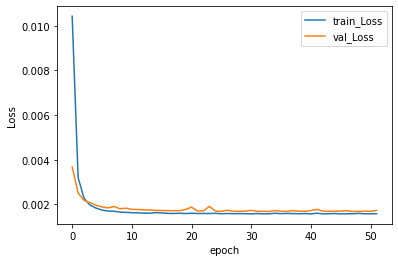

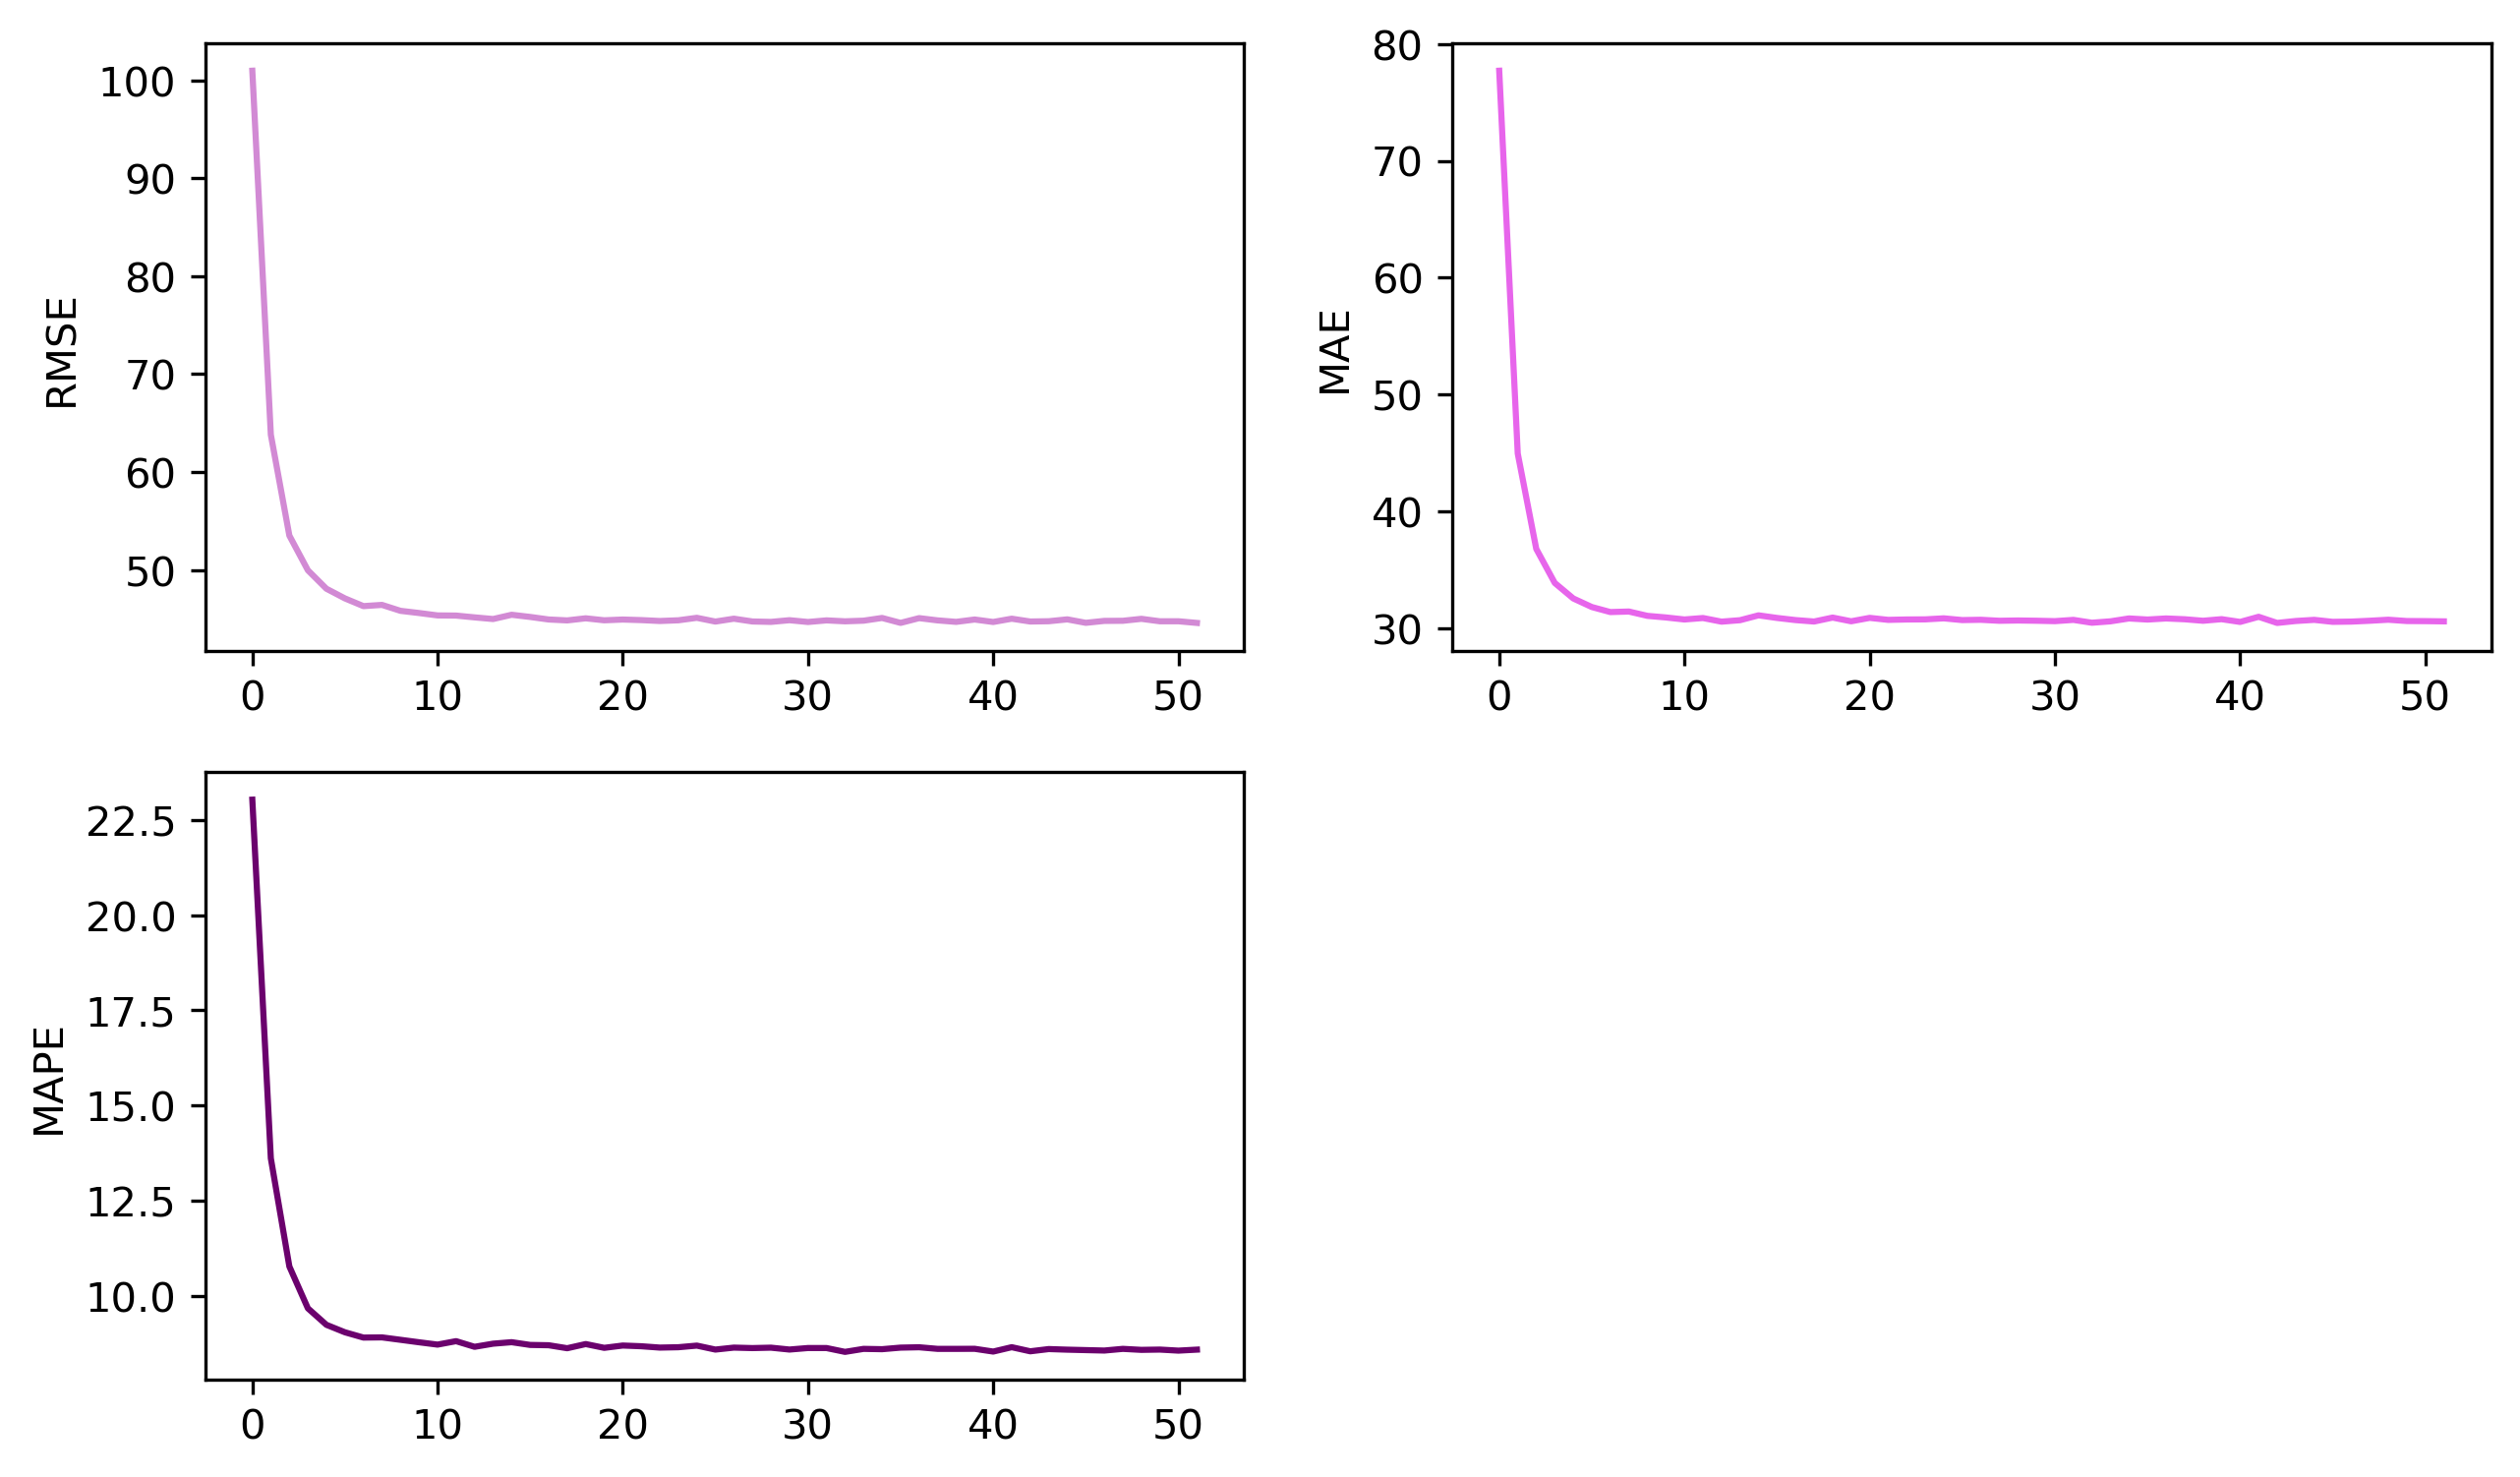

In [17]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)